In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [4]:
from wurlitzer import sys_pipes
from plotnine import *
from mizani.formatters import percent_format
import itertools
import pandas as pd
import numpy as np

from UCP.data import UCPData
import UCP.output as ucp_out
import UCP.model as modeller
import UCP.output.check_solution as ck
import UCP.output.charts as charts
from generic.optimization.solution_extraction import extract_solution

In [5]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [6]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

$\newcommand{\var}[1]{{\color{blue}{#1}}}$
$\newcommand{\EIE}{{\textrm{EIE}}}$
$\newcommand{\ENP}{{\textrm{ENP}}}$

# Unit Commitment Problem (UCP)

## Problem statement:

Schedule power plants $i\in I$ in order to match (hourly) demand $[D_t]_{t\in T}$ over horizon $T=[0,T_\max]$. 

Each power plant can be switched on or off. When on, a power plant's output needs to be between a minimum and a maximum production level.

A power plant has a minimum on/off time, meaning that when it switches state, e.g. from on to off, it needs to wait a certain amount of periods before switching state again.

# Data

Thermal plants: table describing thermal plants

* `plant`: plant id
* `l_cost`: cost function slope
* `c_cost`: cost function constant term
* `min_power`, `max_power`: minimum and maximum production value when plant is on
* `min_on`, `min_off`: minimum on and off time (in hours)


Loads: hourly demand. Relevant fields:
* `period`: hour
* `value`: load

In [7]:
data.thermal_plants

,plant,l_cost,c_cost,min_power,max_power,min_on,min_off
0,0,4.19755,116.761,45.9688,127.349,1,1
1,1,6.79912,287.115,62.7142,185.865,2,3
2,2,7.05905,324.258,69.9785,160.913,2,3
3,3,7.52869,521.159,96.7459,236.831,6,6
4,4,7.02039,200.095,51.2834,151.001,2,3
5,5,7.07212,196.285,60.2507,183.386,2,3
6,6,4.44010,144.004,43.7572,104.979,1,1
7,7,4.92397,119.922,47.1735,113.187,1,1
8,8,4.61960,114.053,42.8216,112.959,1,1
9,9,6.78825,269.271,68.1361,155.159,2,3


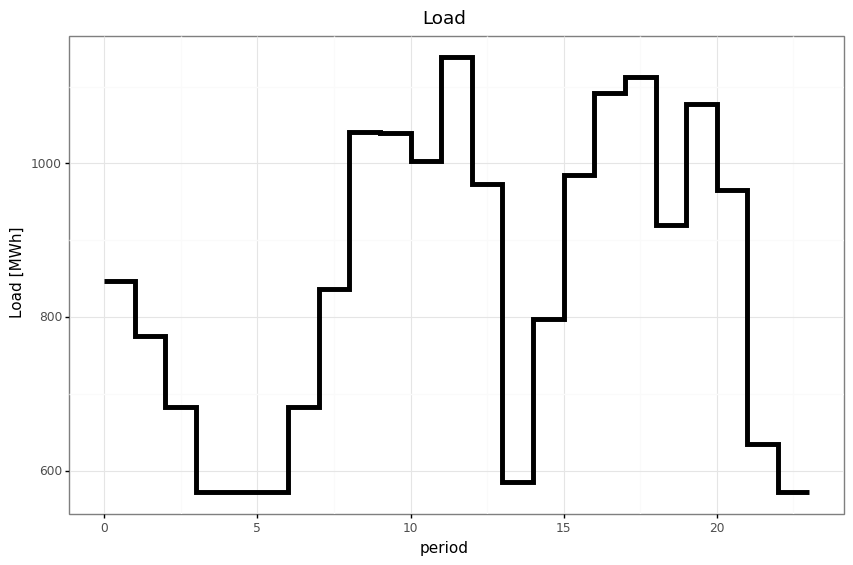

<ggplot: (8789132224756)>

In [8]:
ggplot(data.loads, aes("period", "value")) + geom_step(size=2) + labs(y="Load [MWh]") + ggtitle("Load")

## Model

### Data
for each power plant $i\in I$ and period $t\in T$:
* $\underline{p}_i$, $\bar{p}_i$: min and max production, corresponding to `min_power`, `max_power` `data.thermal_plants`
* $\tau^-$, $\tau^+$: minimum off and on times, corresponding to `min_off`, `min_on` in `data.thermal_plants`
* $l_{i}$, $c_{i}$: linear and constant cost coefficients, corresponding to `l_cost` and `c_cost` in `data.thermal_plants` .<br>
The cost for an active power plant $i$ generating $p\in [\underline{p}_i, \bar{p}_i]$ power is given by a linear function $f_{i}(p) = l_{i} p + c_{i}$.

For each period we have a demand $D_t$, corresponding to `data.loads`.

**Penalties for demand mismatch**

At system level we set a penalty (cost) for mismatching demand, i.e  producing more (Energy in Excess, EIE) or less (Energy Not Provided, ENP) than the actual demand $D_t$.<br> 
We can define different costs for either type of mismatch, defined as $c_\EIE$ and $c_\ENP$ respectively.<br>
In real-world electricity markets these costs are defined as *scarcity prices* and set by market authority, determining the maximum remuneration awarded to producers in the daily electricity markets. <br>
In general, these costs $c$ are required to satisfy the condition $ c > k~ \max_{i\in I} \hat{c}_i$ where $\hat{c}_i$ is the per-unit production cost of a given power plant and $k>1$ is a constant, usually $k>2$. In other words, the penalty for demand mismatch is set to $k$ times the maximum production cost for the power plants, so that it is never convenient for the optimizer (or the producers), to mismatch production and demand.<br>
This *scarcity pricing* idea is often used in modelling to implement *soft constraints*, i.e. constraints that can be violated "a little" but should not be violated in an optimal solution.<br>
In our implementation we over-estimate the maximum production cost as $\hat{c}_i = l_i + \frac{c_i}{\underline{p}_i}$ and use $k=5$ by default.


### Variables

for each power plant $i\in I$ and period $t\in T$:
* $p_{it}$, production level, continuous non-negative
* $s_{it}$, state on/off, binary
* $u^+_{it}$, $u^-_{it}$: up/down variables, binary. $u^+_{it}=1$ iff the power plant switched on at time $t$ ($s_{it}=1$ and $s_{i(t-1)}=0$). Similarly for $u^-_{it}$ and switching off.

at system level:
* $\EIE_{t}$, $\ENP_{t}$: Energy in Excess and Energy not Provided, defined as $\EIE_t = \max(0, \sum_{i\in I} p_{it} - D_t)$ and $\ENP_t = \max(0, D_t - \sum_{i\in I} p_{it})$.

### Model
$$
  \begin{align}
  \min & \sum_{i\in I, t\in T} \left ( l_{i} \var{p_{it}} + c_{i} \var{s_{it}} \right ) + \sum_{t\in T} c_{EIE} \var{EIE_t} + \sum_{t\in T} c_{ENP} \var{ENP_t} \notag \\
  \text{s.t.} ~~ & \underline{p}_i \var{s_{it}} \le \var{p_{it}} \le \bar{p}_i \var{s_{it}} & \forall i\in I, t\in T\\
       & \var{u^+_{it}} \ge \var{s_{it}} - \var{s_{i(t-1)}} & \forall i\in I, t\in T : t > 0\\
       & \var{u^-_{it}} \ge \var{s_{i(t-1)}} - \var{s_{it}} & \forall i\in I, t\in T : t > 0\\
       & \var{s_{it}} \ge \sum_{t'\in \max(0, t-\tau^+_i + 1) \ldots t} \var{u^+_{it'}} & \forall i\in I, t\in T\\
       & \var{s_{it}} \le 1 - \sum_{t'\in \max(0, t-\tau^-_i + 1) \ldots t} \var{u^-_{it'}} & \forall i\in I, t\in T \label{cons:orig-min-down}\\
       & \sum_{i\in I} \var{p_{it}} + \var{\ENP_{t}} = D_t + \var{\EIE_t} & \forall t\in T \quad \\
       & \var{s_{it}}, \var{u^-_{it}}, \var{u^+_{it}} \in \{0, 1\}  & \forall i\in I, t\in T \label{cons:orig-bin-vars} \\
       & \var{p_{it}}, \var{EIE_t}, \var{ENP_t} \in \mathbb{R}^+_0 & \forall i\in I, t\in T
\end{align}
$$

Constraints:

* (1) force production to be between the minimum and maximum for each power plant when they're on ($s_{it}=1$), or zero otherwise ($s_{it}=0$). 
* (2), (3) tie together up and down variables with the state variables of each power plant and period
* (4), (5) define minimum up and down constraints. <br> E.g. (4) says that if the power plant switched on ($u^+_{it'}=1$) in any of the periods $t' in [t-\tau^+ +1,t]$ then the plant must be on at time $t$
* (6) enforces demand satisfaction. Mismatching between production and demand in each period increase the respective EIE and ENP variables. 

# Solution

In [9]:
ucp = modeller.create_model(data)

In [10]:
with sys_pipes():
    ucp.model.solve()
print(f"Cost: {ucp.model.objective.value()}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ataverna_personal/miniconda3/envs/experiments/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/eae839a8fa5f4befbfebdb880b4d472c-pulp.mps branch printingOptions all solution /tmp/eae839a8fa5f4befbfebdb880b4d472c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1909 COLUMNS
At line 8936 RHS
At line 10841 BOUNDS
At line 11562 ENDATA
Problem MODEL has 1904 rows, 1008 columns and 5058 elements
Coin0008I MODEL read with 0 errors
Continuous objective value is 137103 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 132 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 21 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 18 strengthened rows, 0 s

# Output

In [11]:
solution = extract_solution(ucp)

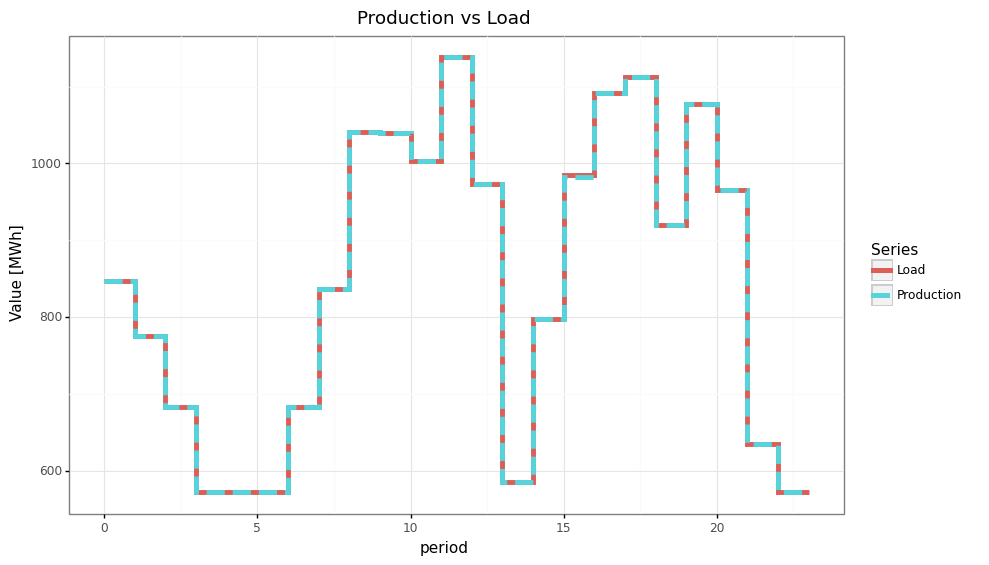

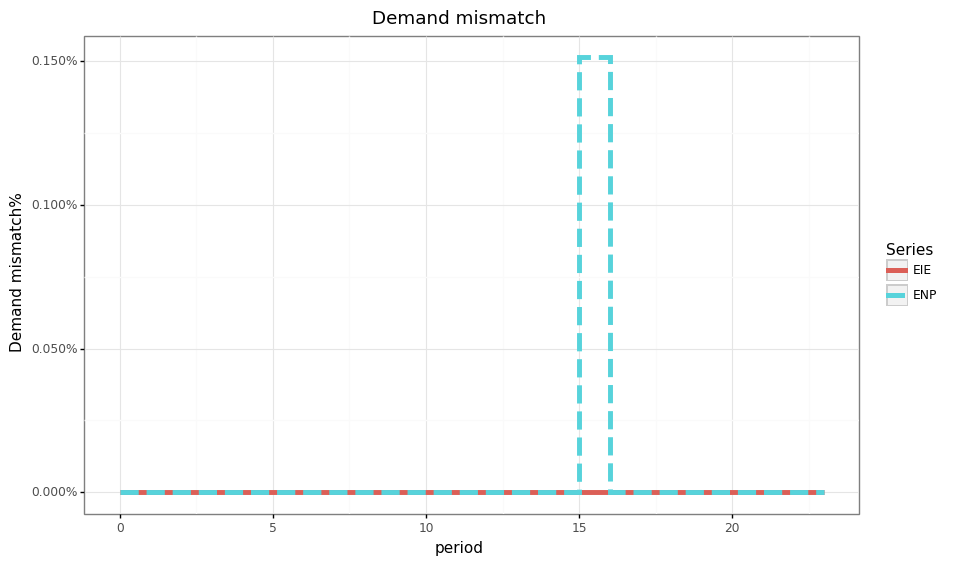

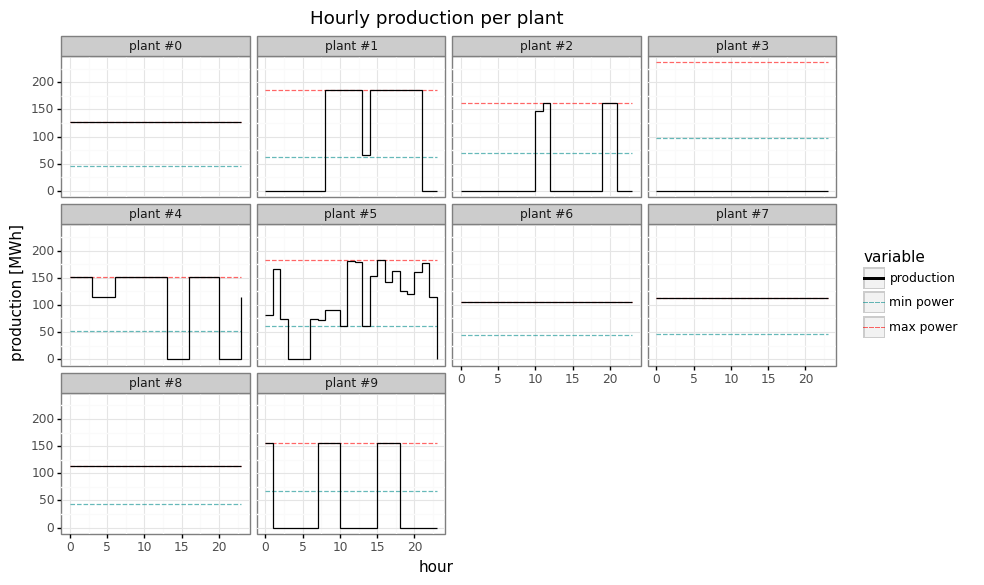

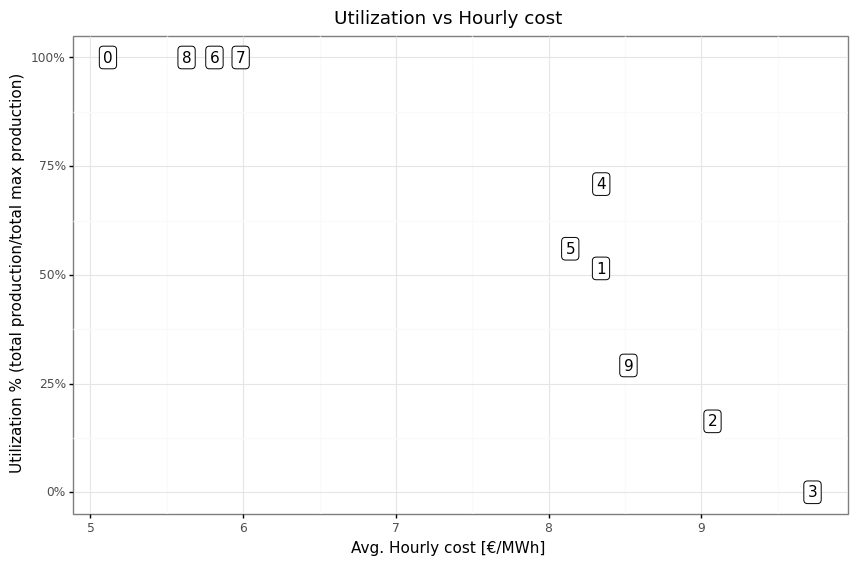

In [12]:
plots = [charts.total_production(data, solution),
 charts.enp_vs_eie(data, solution),
 charts.production_by_plant(data, solution),
 charts.plant_utilization(data, solution)]

for p in plots:
    print(p)